# How do Methylation Fraction and Chemical Potential Affect Cluster Size?

#### Specify Package Root Directory

In [1]:
import os
import sys

# Get the absolute path of the notebook's directory
notebook_directory = os.path.dirname(os.path.abspath('__file__'))

# Navigate one level up to get the root directory path
root_directory = os.path.abspath(os.path.join(notebook_directory, '..'))

# Change the working directory to the root directory
os.chdir(root_directory)

# Append the root directory to sys.path
sys.path.append(root_directory)

#### Import Modules

In [2]:
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sliding_nucleosome.nucleo_arr as nuc

#### Characterize Simulations

In [3]:
# Specify the directory containing all simulations
out_dir = "/scratch/users/jwakim/sliding_nucleosome/output_var_methyl_frac"

# List simulations
sims = os.listdir(out_dir)
sims = [sim for sim in sims if sim.startswith("sim_") and os.path.isdir(os.path.join(out_dir, sim))]
sim_inds = [int(sim.split("_")[1]) for sim in sims]
sims = [sim for _, sim in sorted(zip(sim_inds, sims))]
sim_inds = np.sort(sim_inds)

# We will group methylation fractions into bins
methyl_frac_bin_edges = np.linspace(0, 0.3, 16)

# Simulations vary in methylation fraction and chemical potential
sim_paths = {}
latest_snap_paths = {}
sim_to_methyl_frac_mu = {}
methyl_frac_mu_to_sim = {}
all_methyl_frac_mu = set()

for i, sim in enumerate(sims):
    
    if (i+1) % 50 == 0:
        print(f"Sim {i+1} of {len(sims)}")

    # Identify the latest snapshot
    sim_path = os.path.join(out_dir, sim)
    sim_paths[sim] = sim_path
    snaps = os.listdir(sim_path)
    snaps = [snap for snap in snaps if snap.startswith("snap_") and snap.endswith(".json")]
    snaps = [snap for snap in snaps if snap != "snap_init.json"]
    snap_inds = [int(snap.split("_")[-1].split(".")[0]) for snap in snaps]
    last_snap = snaps[np.argmax(snap_inds)]
    snap_path = os.path.join(sim_path, last_snap)
    latest_snap_paths[sim] = snap_path
    
    # Load configuration
    nuc_arr = nuc.NucleosomeArray.load(snap_path)
    
    # Identify the methylation fraction
    # The methylation fraction represents the lower bound of a bin of width 0.2
    methyl_frac = np.average(nuc_arr.marks[:, 0]) / 2
    methyl_frac = methyl_frac_bin_edges[int(methyl_frac // 0.02)]

    # Identify the chemical potential
    mu = nuc_arr.mu[0]
    
    # Generate a string representation of the methylation fraction and chemical potential
    methyl_frac_mu = f"{methyl_frac}_{mu}"
    sim_to_methyl_frac_mu[sim] = methyl_frac_mu
    
    # Store the chain length
    if methyl_frac_mu not in all_methyl_frac_mu:
        methyl_frac_mu_to_sim[methyl_frac_mu] = [sim]
        all_methyl_frac_mu.add(methyl_frac_mu)
    else:
        methyl_frac_mu_to_sim[methyl_frac_mu].append(sim)

Sim 50 of 1134
Sim 100 of 1134
Sim 150 of 1134
Sim 200 of 1134
Sim 250 of 1134
Sim 300 of 1134
Sim 350 of 1134
Sim 400 of 1134
Sim 450 of 1134
Sim 500 of 1134
Sim 550 of 1134
Sim 600 of 1134
Sim 650 of 1134
Sim 700 of 1134
Sim 750 of 1134
Sim 800 of 1134
Sim 850 of 1134
Sim 900 of 1134
Sim 950 of 1134
Sim 1000 of 1134
Sim 1050 of 1134
Sim 1100 of 1134


#### Compute Average In-Range Parameter (Gamma)

In [4]:
all_methyl_frac_mu_lst = list(methyl_frac_mu_to_sim.keys())

print("Methylation Fractions and Chemical Potentials:\n")
pprint(all_methyl_frac_mu_lst)

Methylation Fractions and Chemical Potentials:

['0.06_-9.9',
 '0.0_-9.9',
 '0.02_-9.9',
 '0.04_-9.9',
 '0.08_-9.9',
 '0.1_-9.9',
 '0.16_-9.9',
 '0.0_-9.8',
 '0.02_-9.8',
 '0.06_-9.8',
 '0.04_-9.8',
 '0.14_-9.9',
 '0.08_-9.8',
 '0.12_-9.8',
 '0.1_-9.8',
 '0.16_-9.8',
 '0.14_-9.8',
 '0.02_-9.7',
 '0.08_-9.7',
 '0.06_-9.7',
 '0.0_-9.7',
 '0.04_-9.7',
 '0.1_-9.7',
 '0.12_-9.7',
 '0.0_-9.6',
 '0.04_-9.6',
 '0.02_-9.6',
 '0.06_-9.6',
 '0.08_-9.6',
 '0.12_-9.6',
 '0.1_-9.6',
 '0.04_-9.5',
 '0.02_-9.5',
 '0.06_-9.5',
 '0.0_-9.5',
 '0.1_-9.5',
 '0.08_-9.5',
 '0.12_-9.5',
 '0.14_-9.5',
 '0.18_-9.8',
 '0.16_-9.7',
 '0.18_-9.7',
 '0.14_-9.7',
 '0.22_-9.7',
 '0.14_-9.6',
 '0.16_-9.6',
 '0.22_-9.6']


In [5]:
all_avg_gamma = {}
all_methyl_frac = set()

for methyl_frac_mu in all_methyl_frac_mu_lst:
    
    methyl_frac = float(methyl_frac_mu.split("_")[0])
    if methyl_frac not in all_methyl_frac:
        all_avg_gamma[methyl_frac] = {}
        all_methyl_frac.add(methyl_frac)
    
    mu = float(methyl_frac_mu.split("_")[1])
    all_avg_gamma[methyl_frac][mu] = {}
    
    sims = methyl_frac_mu_to_sim[methyl_frac_mu]

    for sim in sims:

        # Identify latest snapshot
        sim_path = sim_paths[sim]
        snap_path = latest_snap_paths[sim]

        # Load configuration
        nuc_arr = nuc.NucleosomeArray.load(snap_path)

        # Compute average gamma parameter
        all_avg_gamma[methyl_frac][mu][sim] = np.average(nuc_arr.gamma)

#### Plot Gamma vs. Chemical Potential for Fixed Chain Length

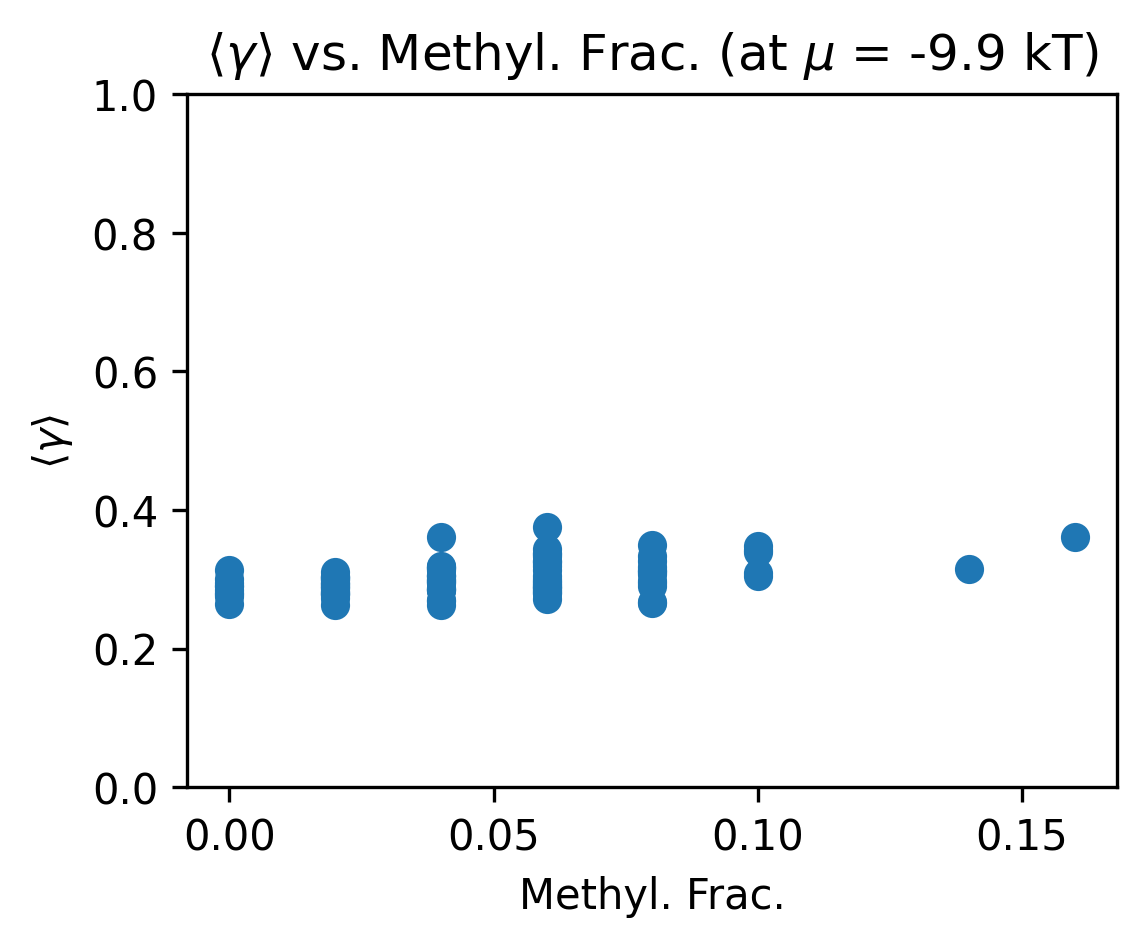

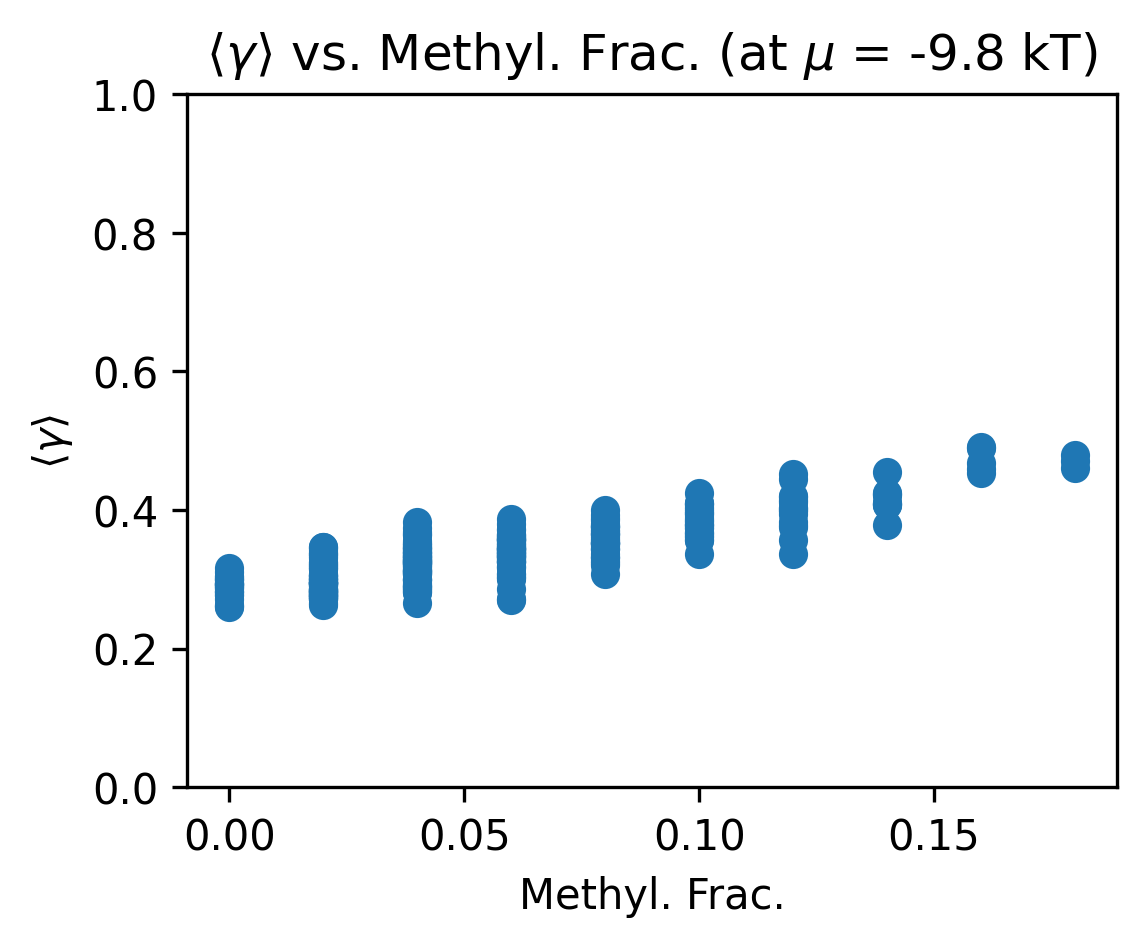

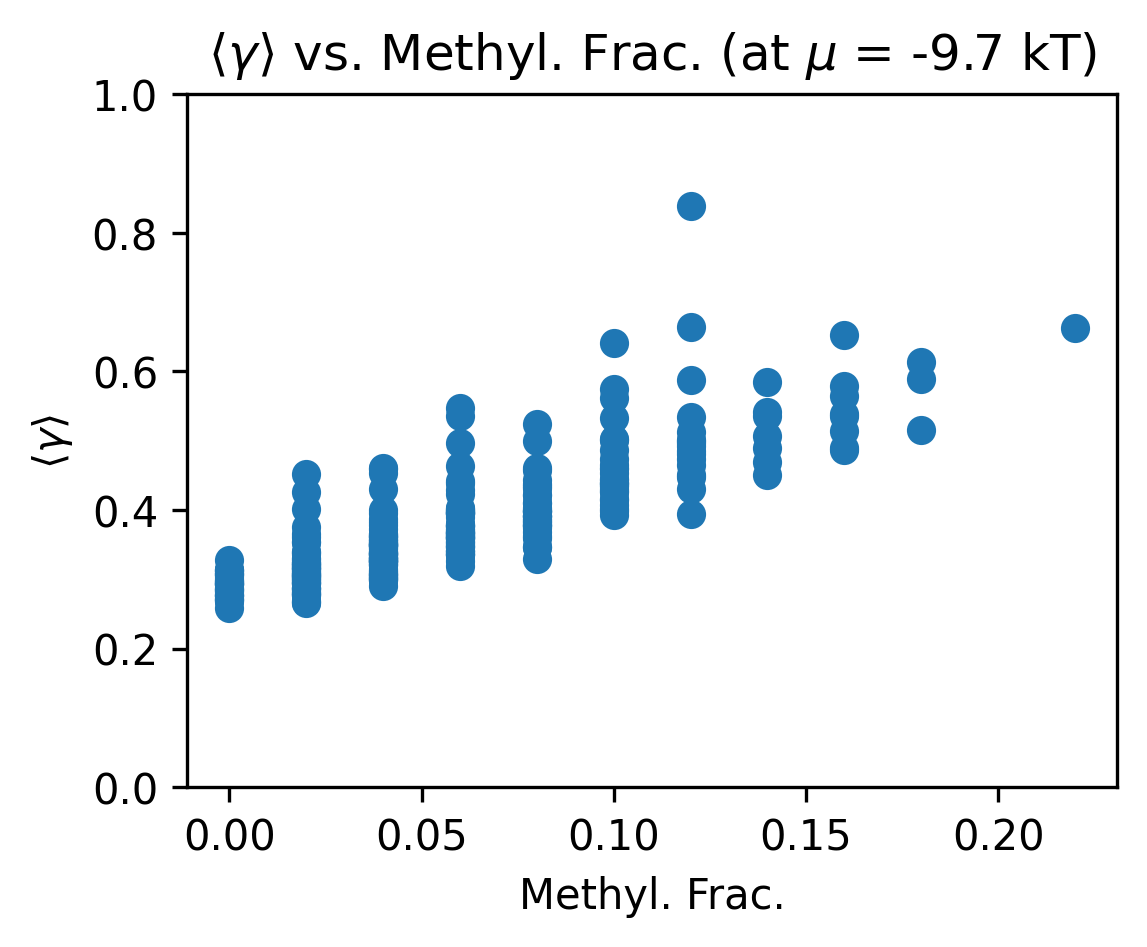

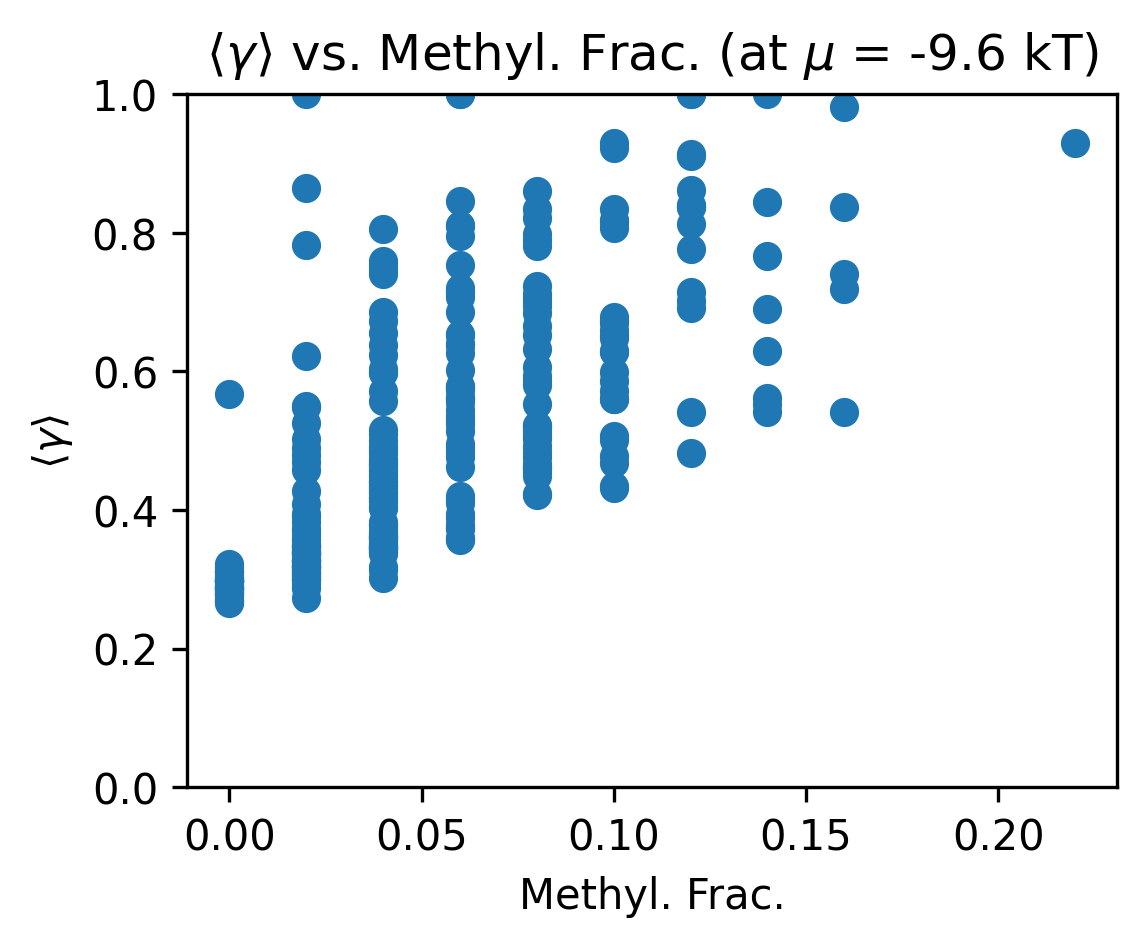

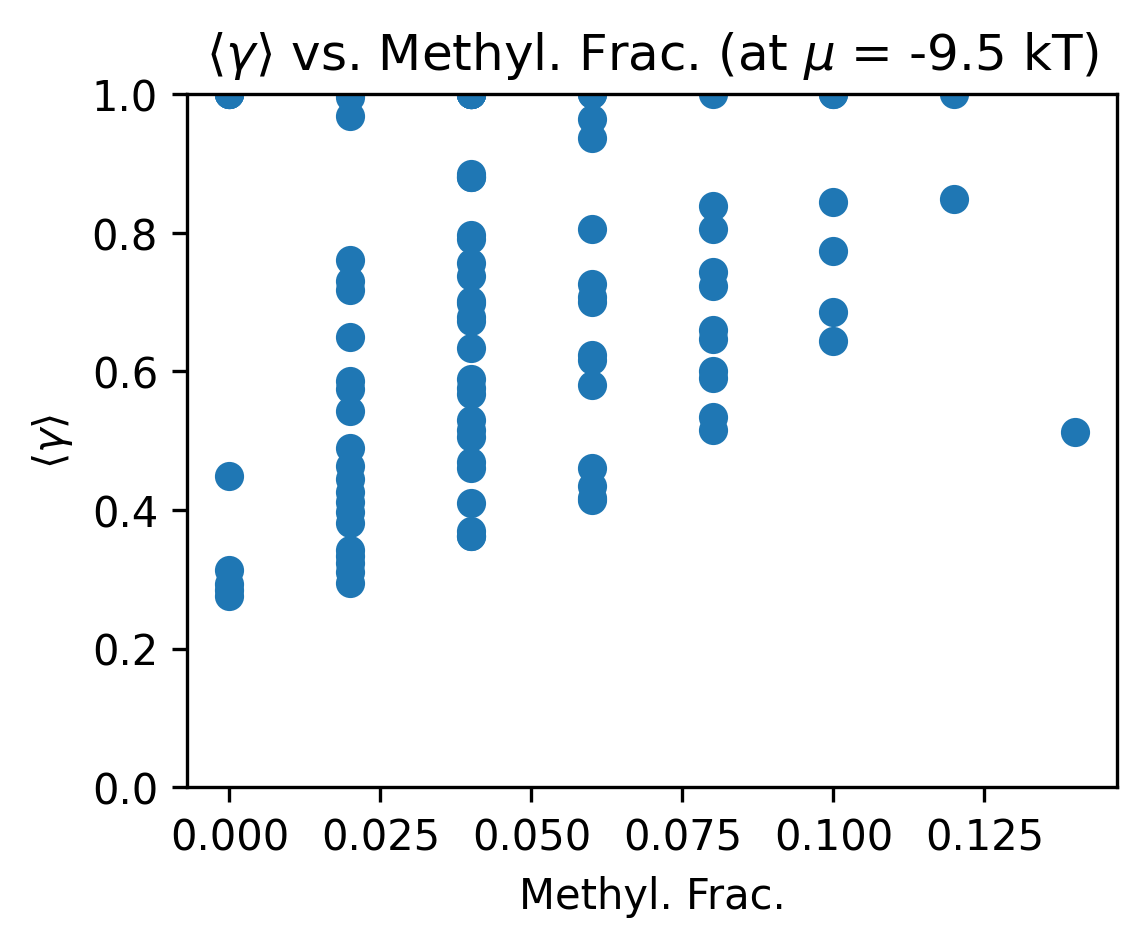

In [6]:
# Prepare data for plotting
methyl_frac_plot = []
mu_plot = []
avg_gamma_plot = []

for methyl_frac in all_avg_gamma.keys():
    for mu in all_avg_gamma[methyl_frac].keys():
        for sim in all_avg_gamma[methyl_frac][mu]:
            methyl_frac_plot.append(methyl_frac)
            mu_plot.append(mu)
            avg_gamma_plot.append(all_avg_gamma[methyl_frac][mu][sim])

# Covert to numpy arrays (for easier indexing)
methyl_frac_plot = np.array(methyl_frac_plot)
mu_plot = np.array(mu_plot)
avg_gamma_plot = np.array(avg_gamma_plot)
unique_mu = np.unique(mu_plot)

# For each chemical potential, plot average gamma vs methylation fraction
for mu in unique_mu:
    inds = (mu_plot == mu)
    plt.figure(figsize=(4, 3), dpi=300)
    plt.scatter(methyl_frac_plot[inds], avg_gamma_plot[inds])
    plt.xlabel(r"Methyl. Frac.")
    plt.ylabel(r"$\langle\gamma\rangle$")
    plt.ylim((0, 1))
    plt.title(fr"$\langle\gamma\rangle$ vs. Methyl. Frac. (at $\mu$ = {mu} kT)")
    plt.show()

#### Load Cluster Size Distributions

In [7]:
def has_only_one_line(file_path):
    """So I can skip empty Rg files.
    """
    try:
        with open(file_path, 'r') as file:
            first_line = file.readline()
            return first_line and file.readline() == ''
    except IOError:
        return False

In [8]:
# Specify the file into which Rg was stored for 3D realizations of simulated chain lengths
# This file is created by get_Rg.py
Rg_file = "Rg_dist.csv"

# Load the cluster size distribution for each simulation
cluster_sizes = {}
for sim, sim_path in sim_paths.items():
    # Check if cluster sizes were evaluated for the simulation
    Rg_path = os.path.join(sim_path, Rg_file)
    if not os.path.exists(Rg_path):
        print(f"Missing Rg: {sim}")
        continue
    if has_only_one_line(Rg_path):
        print(f"Empy Rg: {sim}")
        continue

    cluster_sizes[sim] = np.loadtxt(Rg_path, skiprows=1)

# Organize cluster sizes by chemical potential and methylation fraction
cluster_sizes_by_mu_methyl_frac = {mu: {} for mu in unique_mu}
methyl_fracs_by_mu = {mu: set() for mu in unique_mu}
for methyl_frac in all_avg_gamma.keys():
    for mu in all_avg_gamma[methyl_frac].keys():
        sims = list(all_avg_gamma[methyl_frac][mu].keys())
        cluster_sizes_lst = [cluster_sizes[sim] for sim in sims]
        cluster_sizes_by_mu_methyl_frac[mu][methyl_frac] = \
            np.concatenate(cluster_sizes_lst)

In [9]:
pprint(cluster_sizes_by_mu_methyl_frac[-9.9][0.0].shape)

(44000,)


#### Plot Cluster Size Distributions

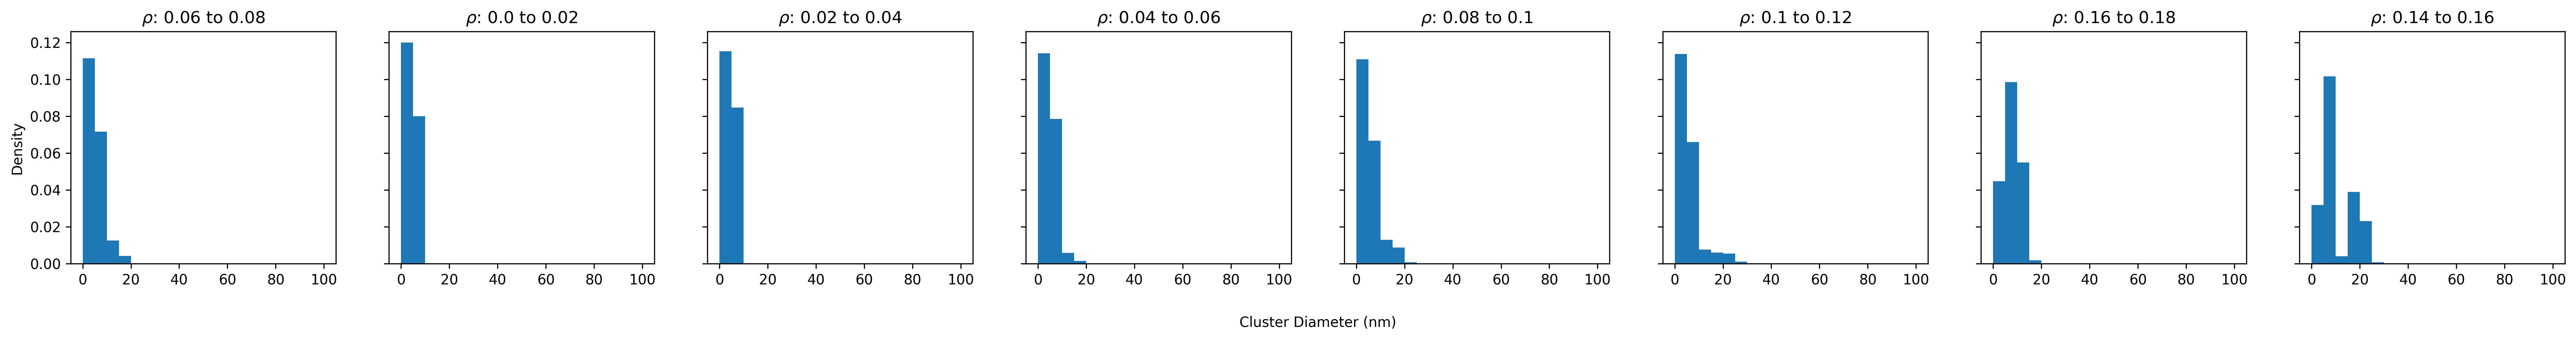

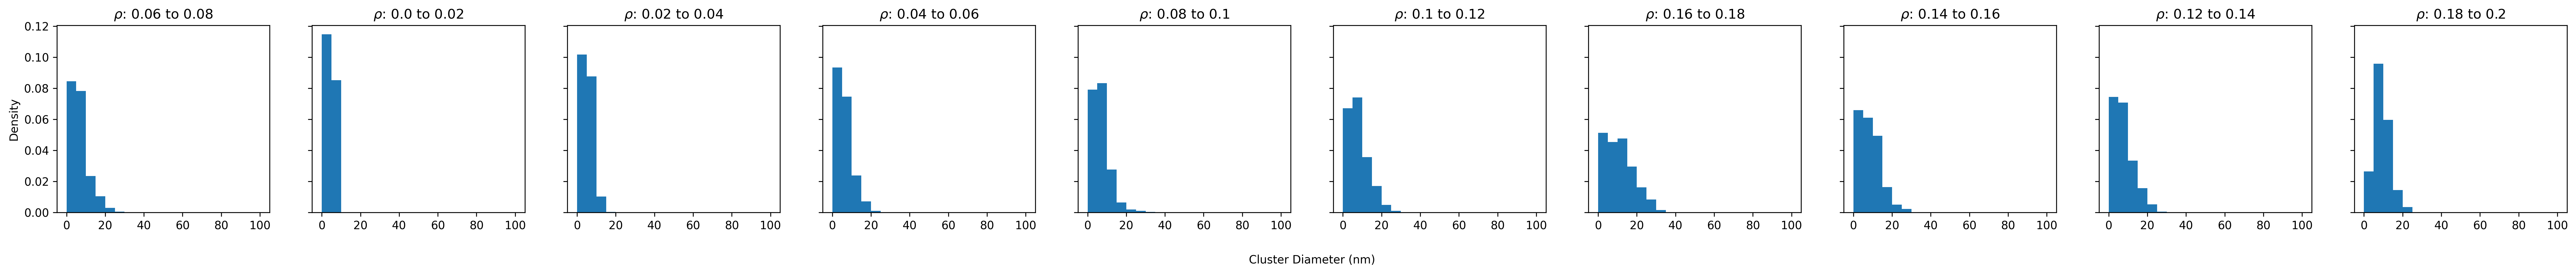

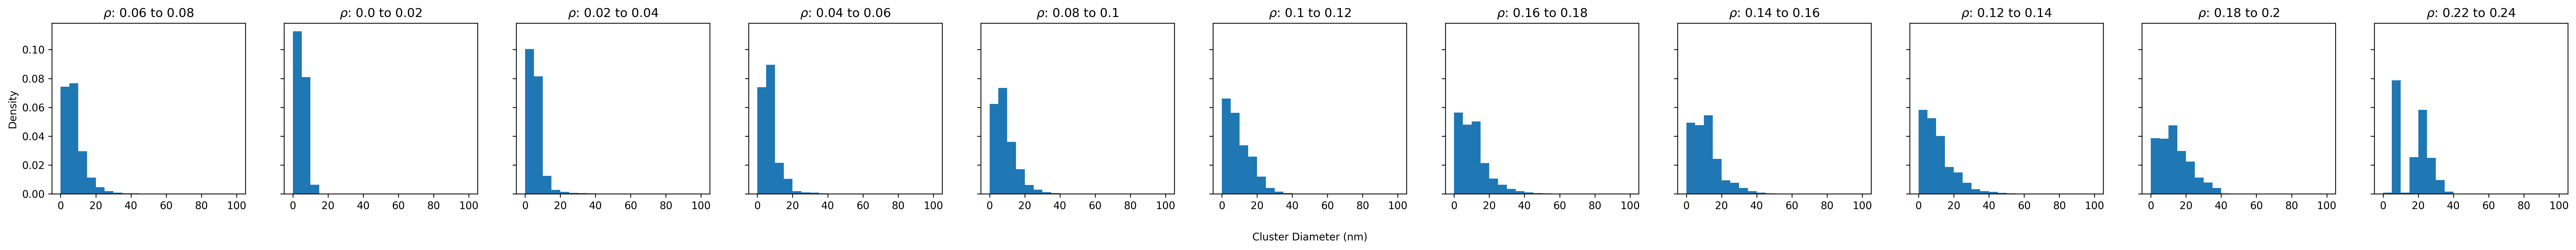

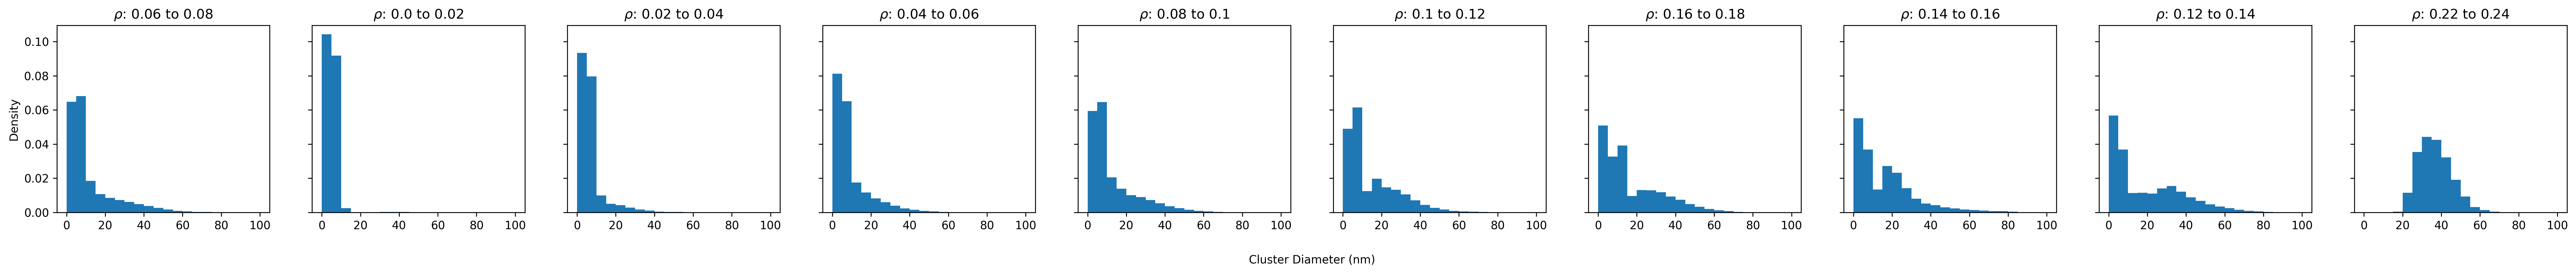

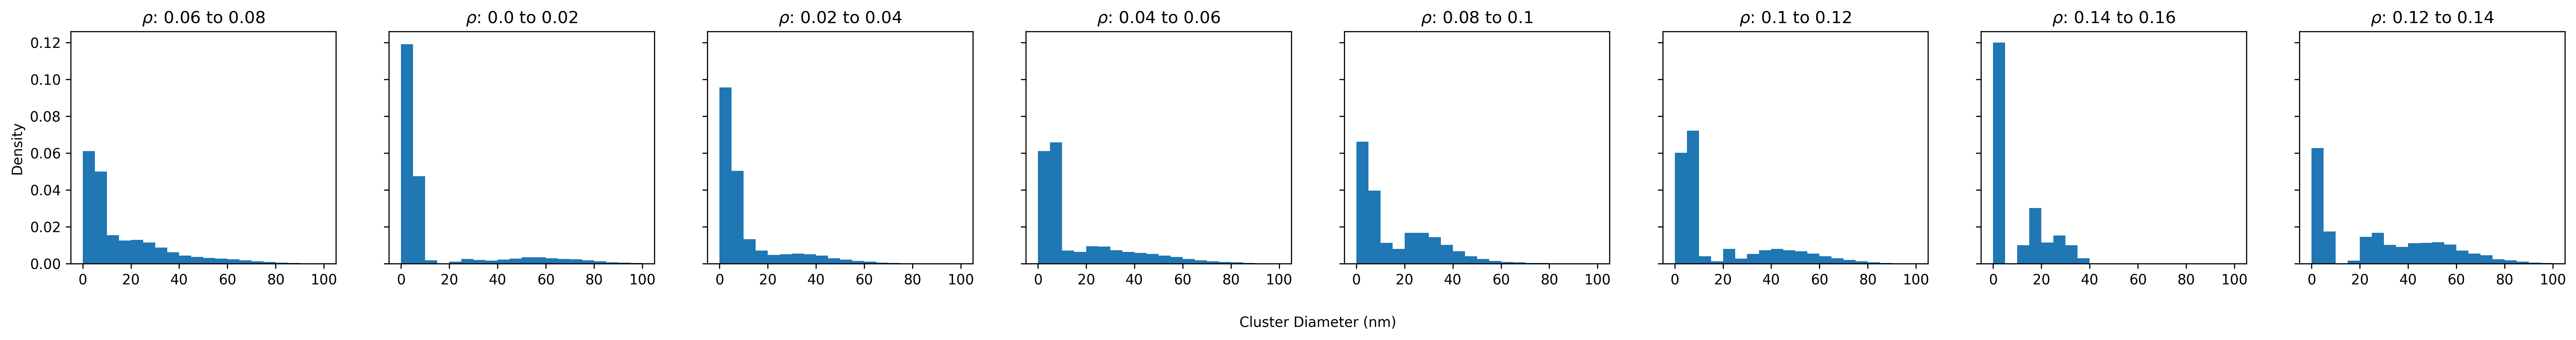

In [10]:
bins = np.linspace(0, 100, 21)
for mu, cluster_size_dist in cluster_sizes_by_mu_methyl_frac.items():
    
    # We will include a separate subplot for each methylation fraction
    methyl_fracs_ = list(cluster_size_dist.keys())
    n_subplots = len(methyl_fracs_)
    
    fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(n_subplots*4, 3), dpi=300, sharey=True)
    
    if n_subplots == 1:
        axes.hist(cluster_size_dist[methyl_frac_], bins=bins, density=True)
        axes.set_title(fr"$\rho$: {methyl_frac_} to {round(methyl_frac_ + 0.02, 2)}")
        axes.set_ylabel("Density")
        axes.set_xlabel("Cluster Diameter (nm)")
    else:
        for i, methyl_frac_ in enumerate(methyl_fracs_):
            axes[i].hist(cluster_size_dist[methyl_frac_], bins=bins, density=True)
            axes[i].set_title(fr"$\rho$: {methyl_frac_} to {round(methyl_frac_ + 0.02, 2)}")
        axes[0].set_ylabel("Density")
        x_label_pos = (axes[0].get_position().x0 + axes[-1].get_position().x1) / 2
        fig.text(x_label_pos, -0.1, "Cluster Diameter (nm)", ha="center")
    
    plt.show()

#### Use the Same Bin Edges as [ChromEMT](https://www.science.org/doi/10.1126/science.aag0025#supplementary-materials)

-9.9


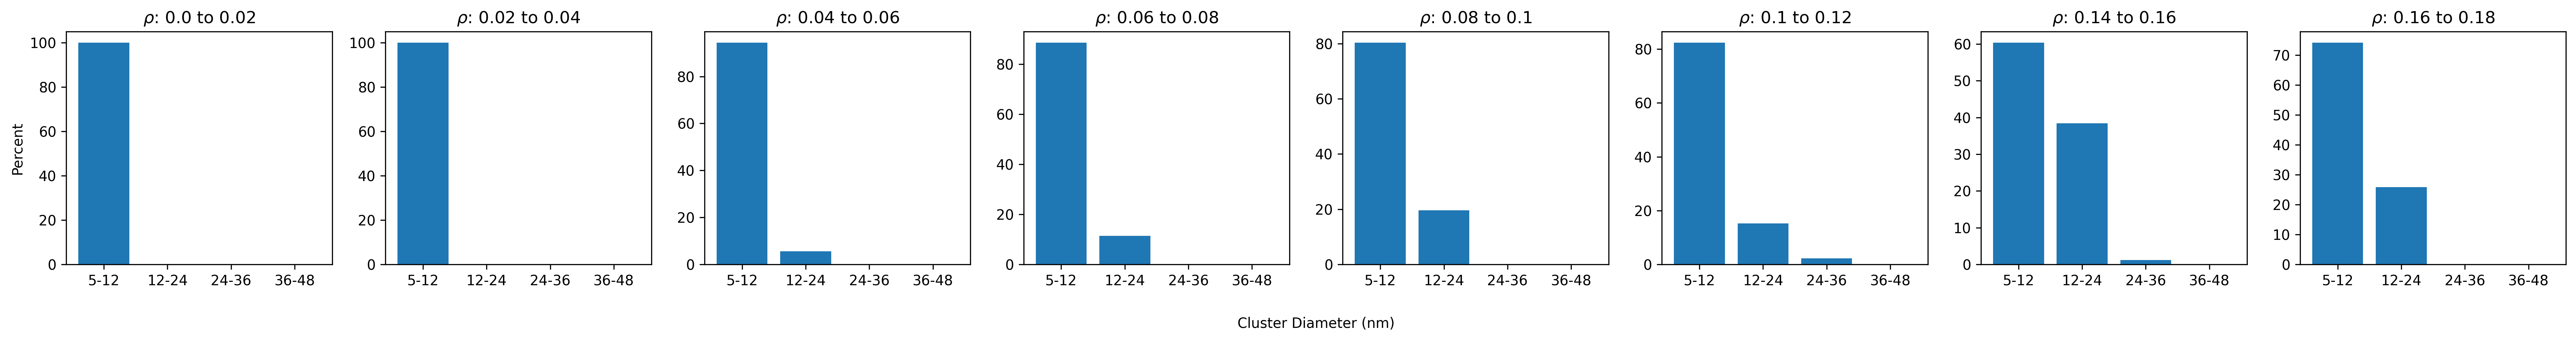

-9.8


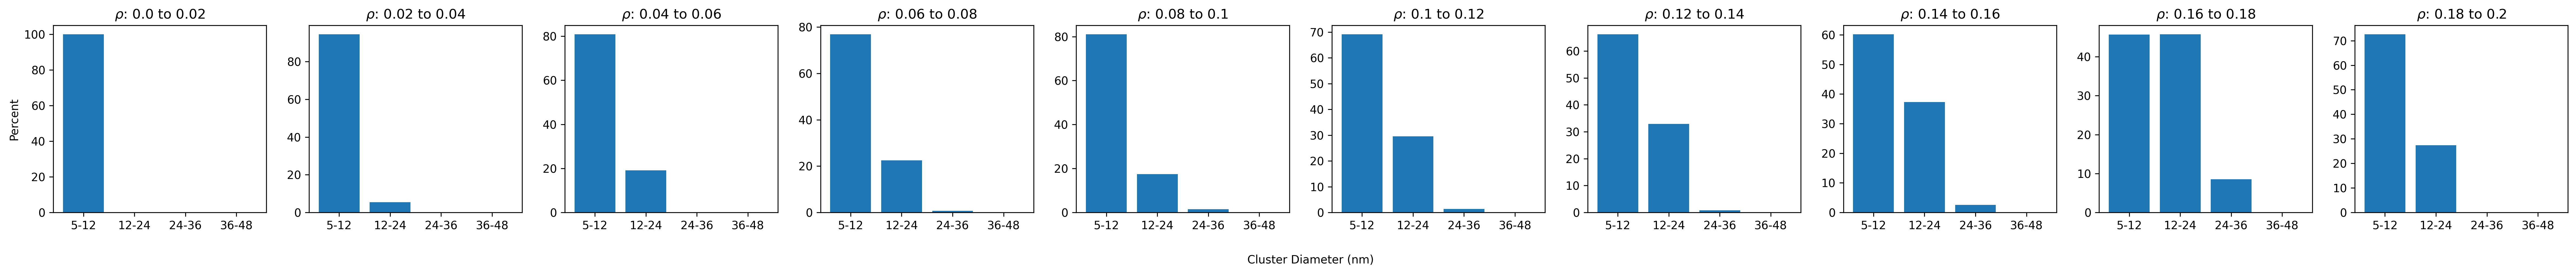

-9.7


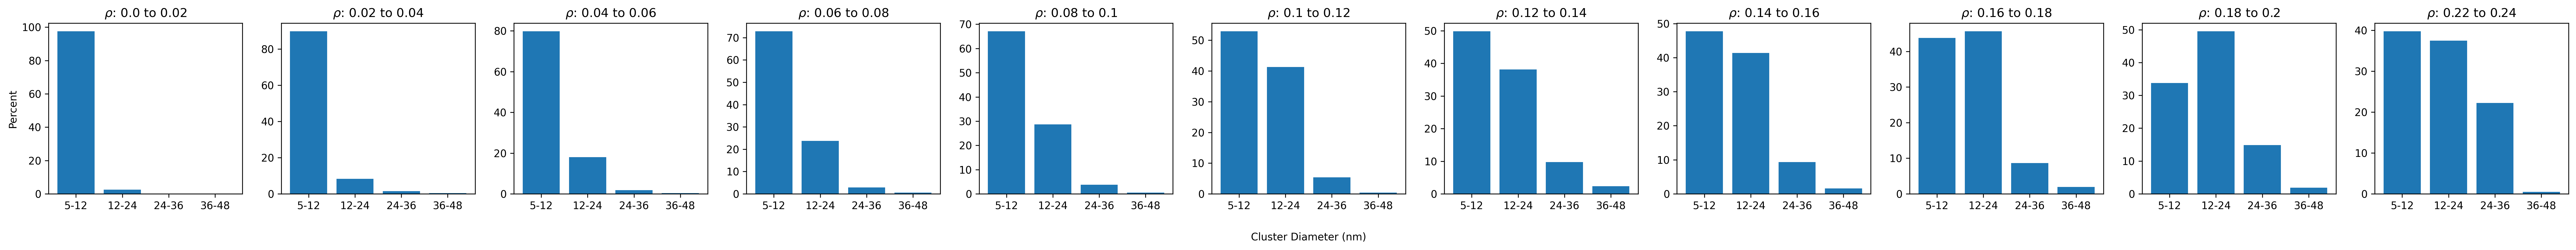

-9.6


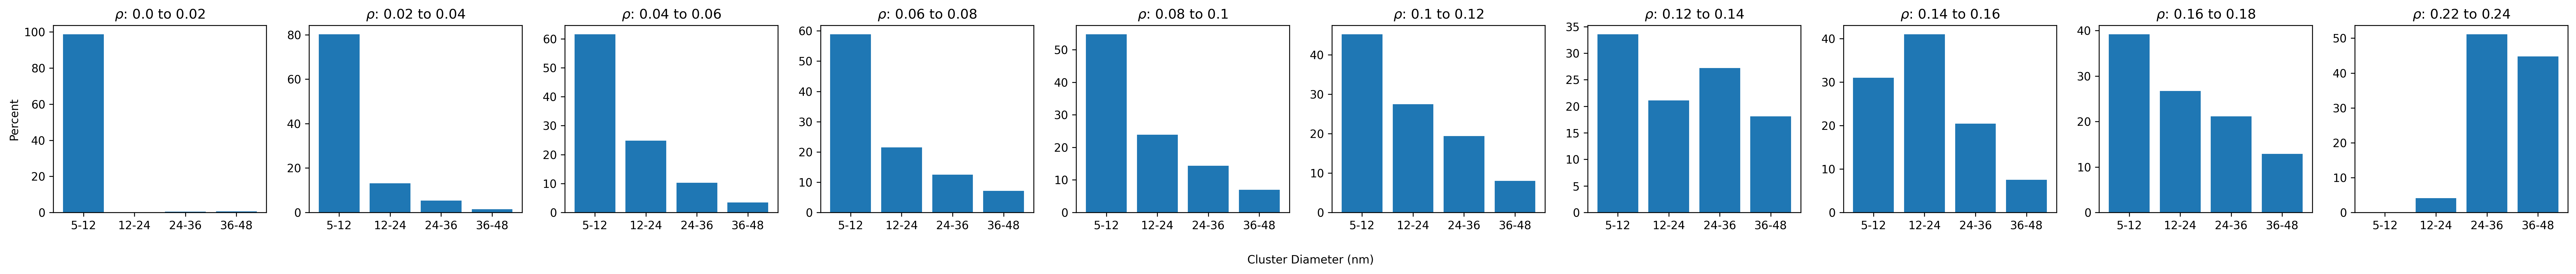

-9.5


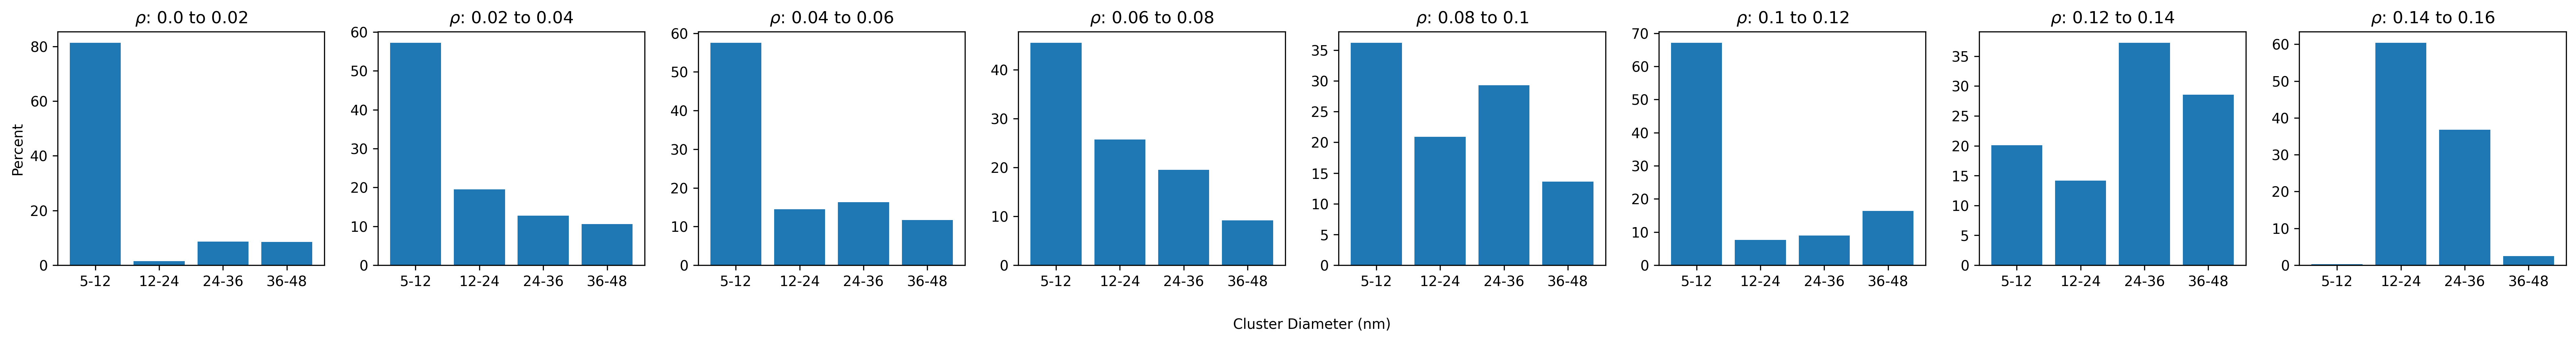

In [11]:
bins = [5, 12, 24, 36, 48]
for mu, cluster_size_dist in cluster_sizes_by_mu_methyl_frac.items():
    
    # We will include a separate subplot for each methylation fraction
    methyl_fracs_ = list(cluster_size_dist.keys())
    methyl_fracs_ = np.sort(methyl_fracs_)
    n_subplots = len(methyl_fracs_)
    
    print(mu)
    
    fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(n_subplots*4, 3), dpi=300, sharey=False)
    
    for i, methyl_frac_ in enumerate(methyl_fracs_):
        hist, _ = np.histogram(cluster_size_dist[methyl_frac_], bins=bins, density=False)
        hist_percent = (hist / np.sum(hist)) * 100
        bar_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
        axes[i].bar(bar_labels, hist_percent, align='center')
        axes[i].set_title(fr"$\rho$: {methyl_frac_} to {round(methyl_frac_ + 0.02, 2)}")
    
    axes[0].set_ylabel("Percent")
    x_label_pos = (axes[0].get_position().x0 + axes[-1].get_position().x1) / 2
    fig.text(x_label_pos, -0.1, "Cluster Diameter (nm)", ha="center")
    
    plt.show()

-9.9


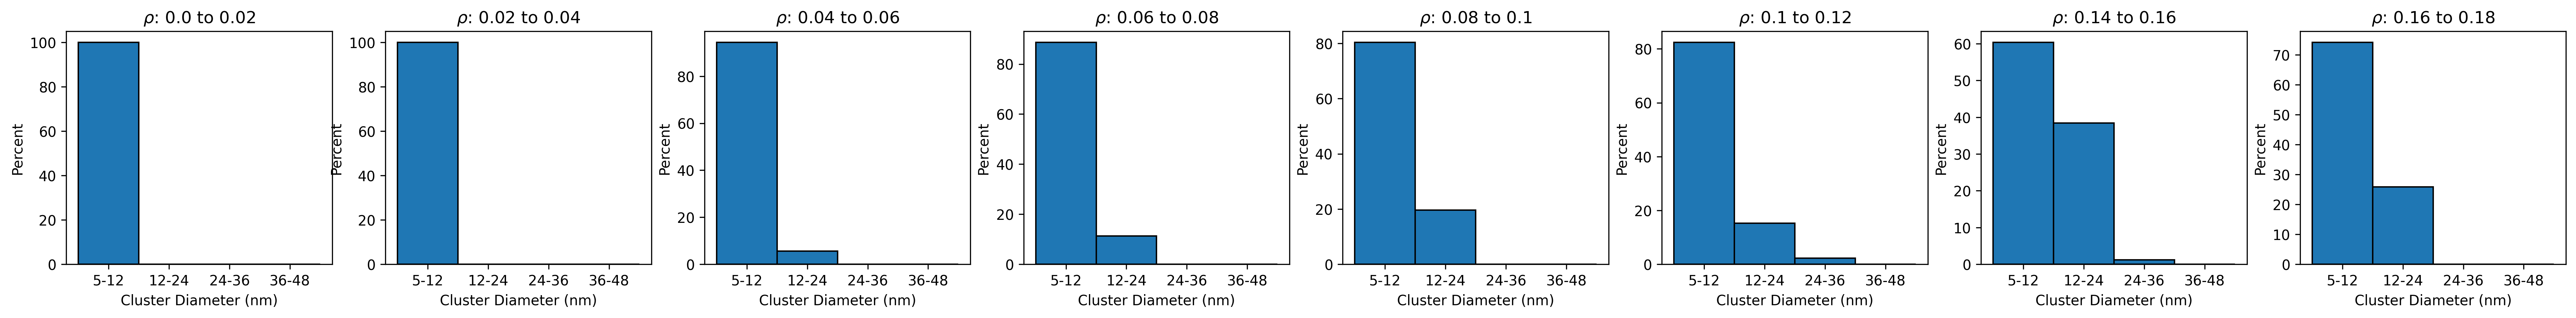

-9.8


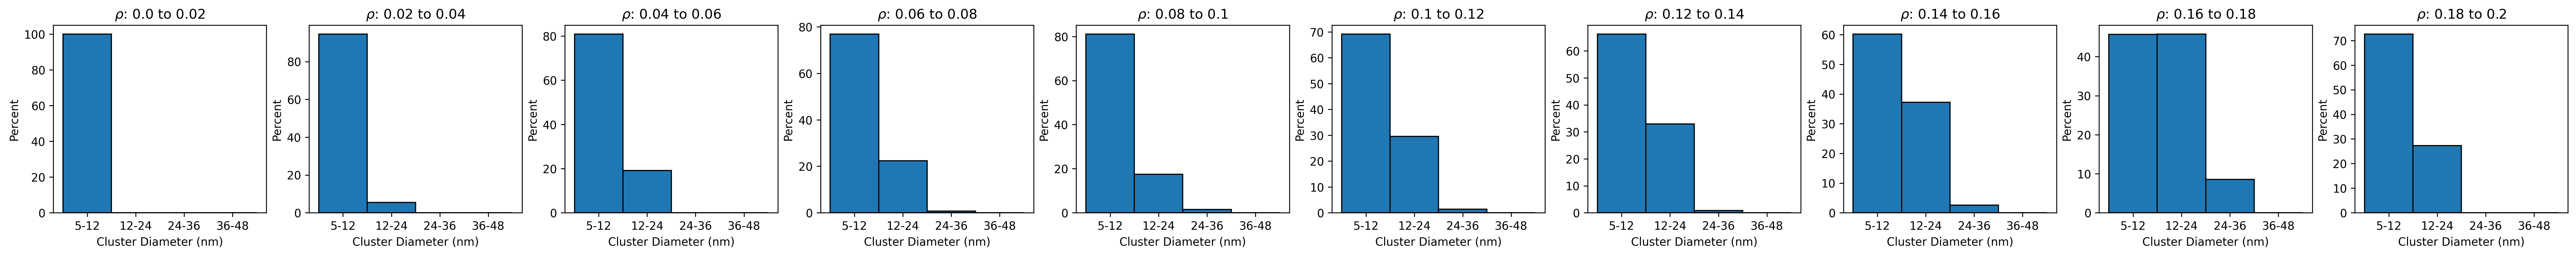

-9.7


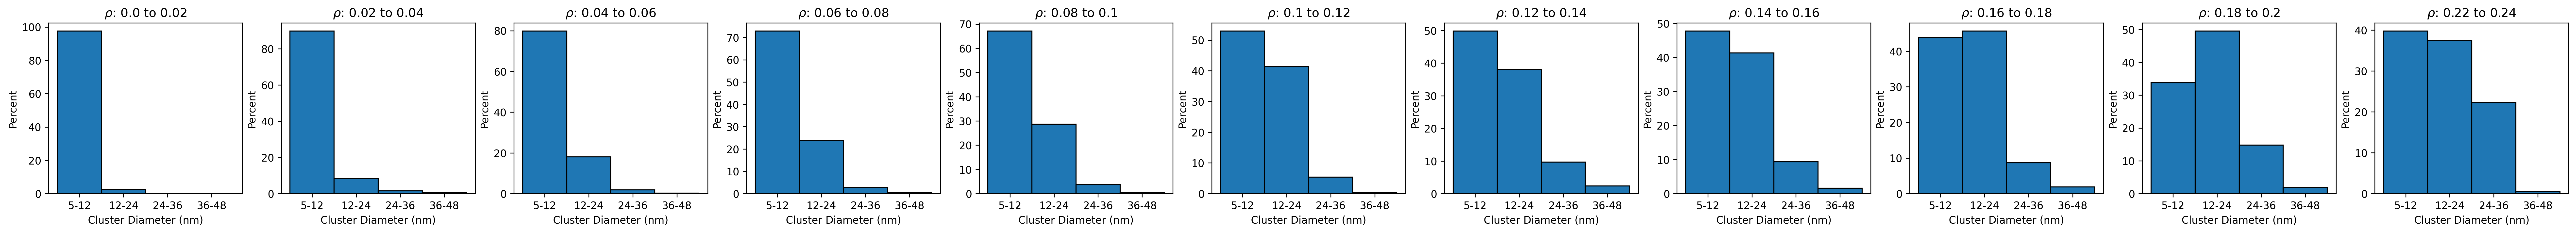

-9.6


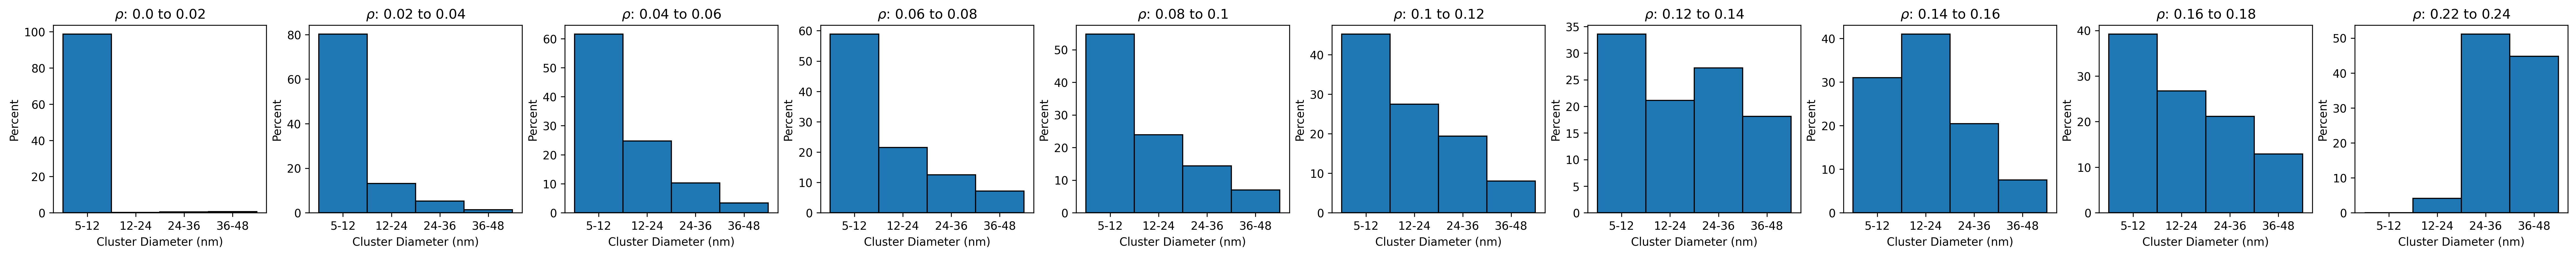

-9.5


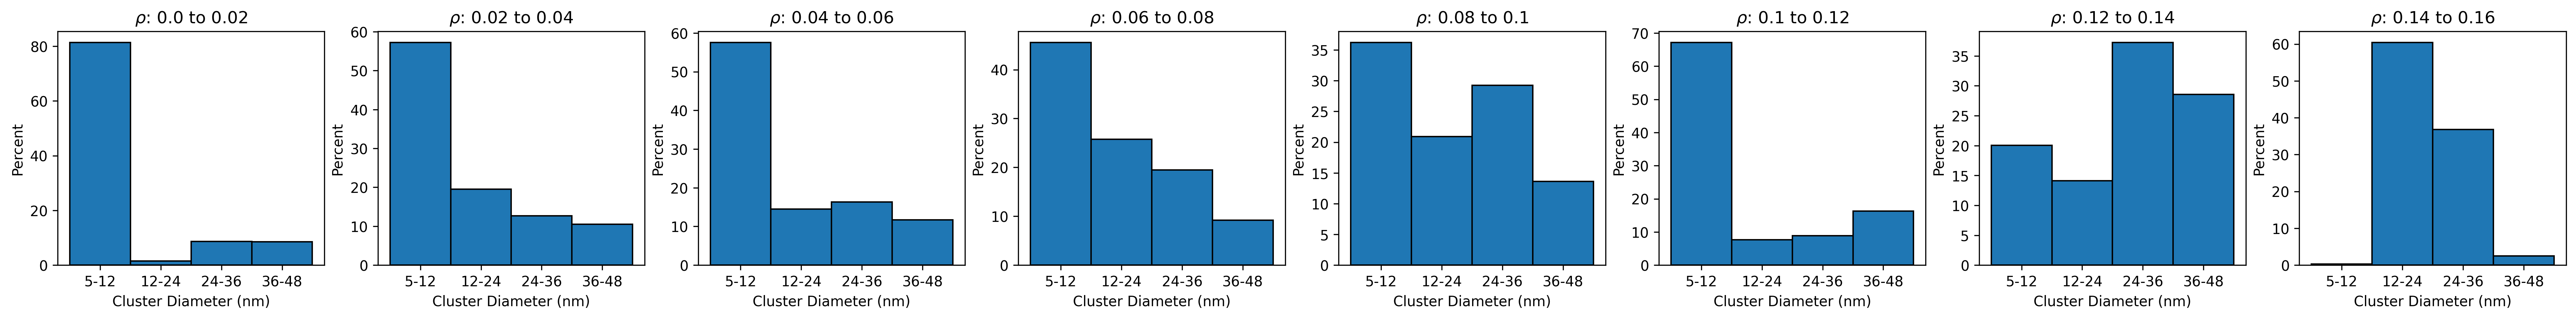

In [12]:
bins = [5, 12, 24, 36, 48]
for mu, cluster_size_dist in cluster_sizes_by_mu_methyl_frac.items():
    
    # We will include a separate subplot for each methylation fraction
    methyl_fracs_ = list(cluster_size_dist.keys())
    methyl_fracs_ = np.sort(methyl_fracs_)
    n_subplots = len(methyl_fracs_)
    
    print(mu)
    
    fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(n_subplots*4, 3), dpi=300, sharey=False)
    
    for i, methyl_frac_ in enumerate(methyl_fracs_):
        hist, _ = np.histogram(cluster_size_dist[methyl_frac_], bins=bins, density=False)
        hist_percent = (hist / np.sum(hist)) * 100
        bar_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
        axes[i].bar(bar_labels, hist_percent, width=1, align='center', edgecolor="black")
        axes[i].set_title(fr"$\rho$: {methyl_frac_} to {round(methyl_frac_ + 0.02, 2)}")
        axes[i].set_xlabel("Cluster Diameter (nm)")
        axes[i].set_ylabel("Percent")
    
    plt.show()

#### How does mean cluster size vary with mark abundance?

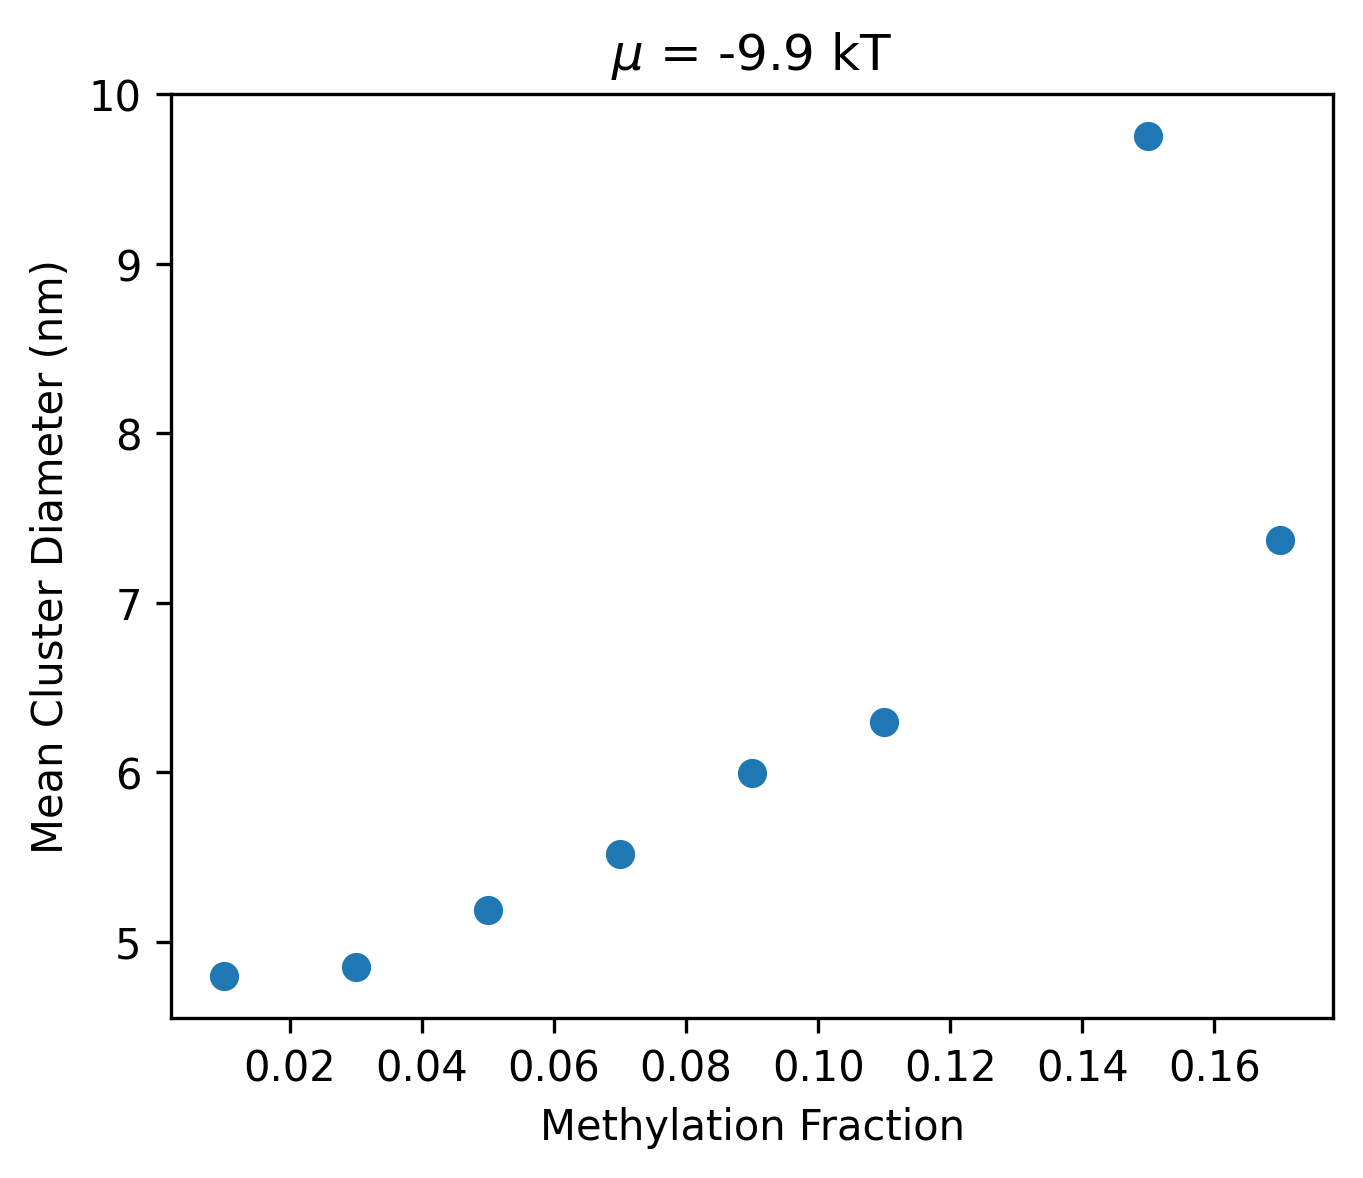

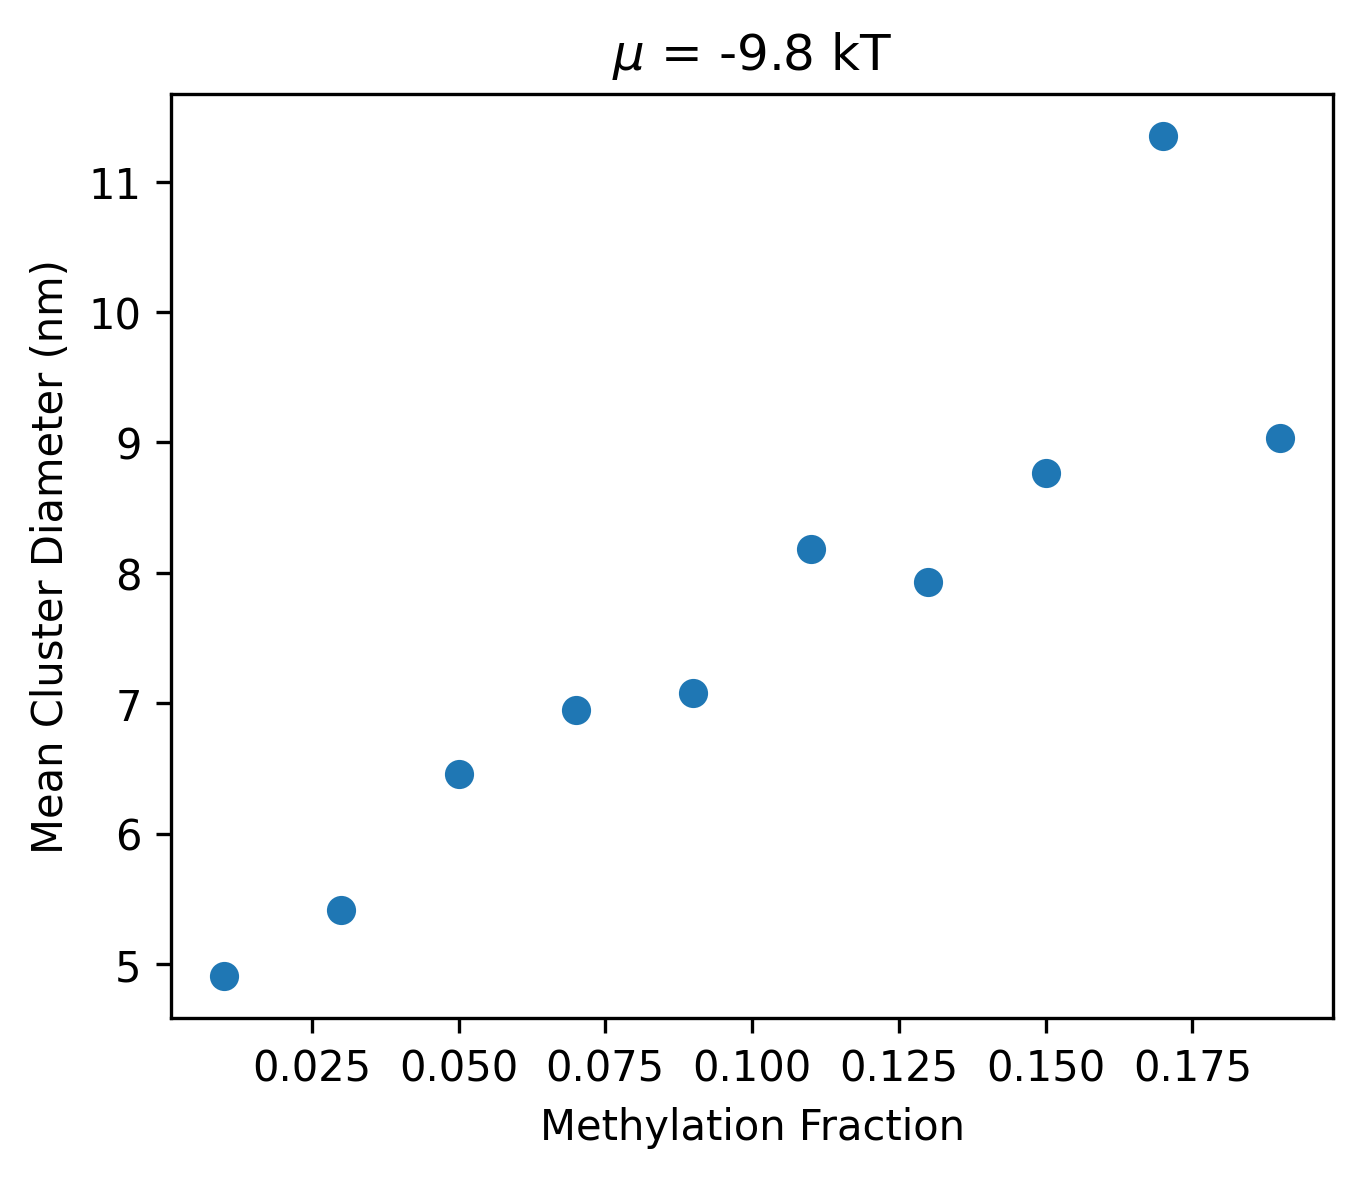

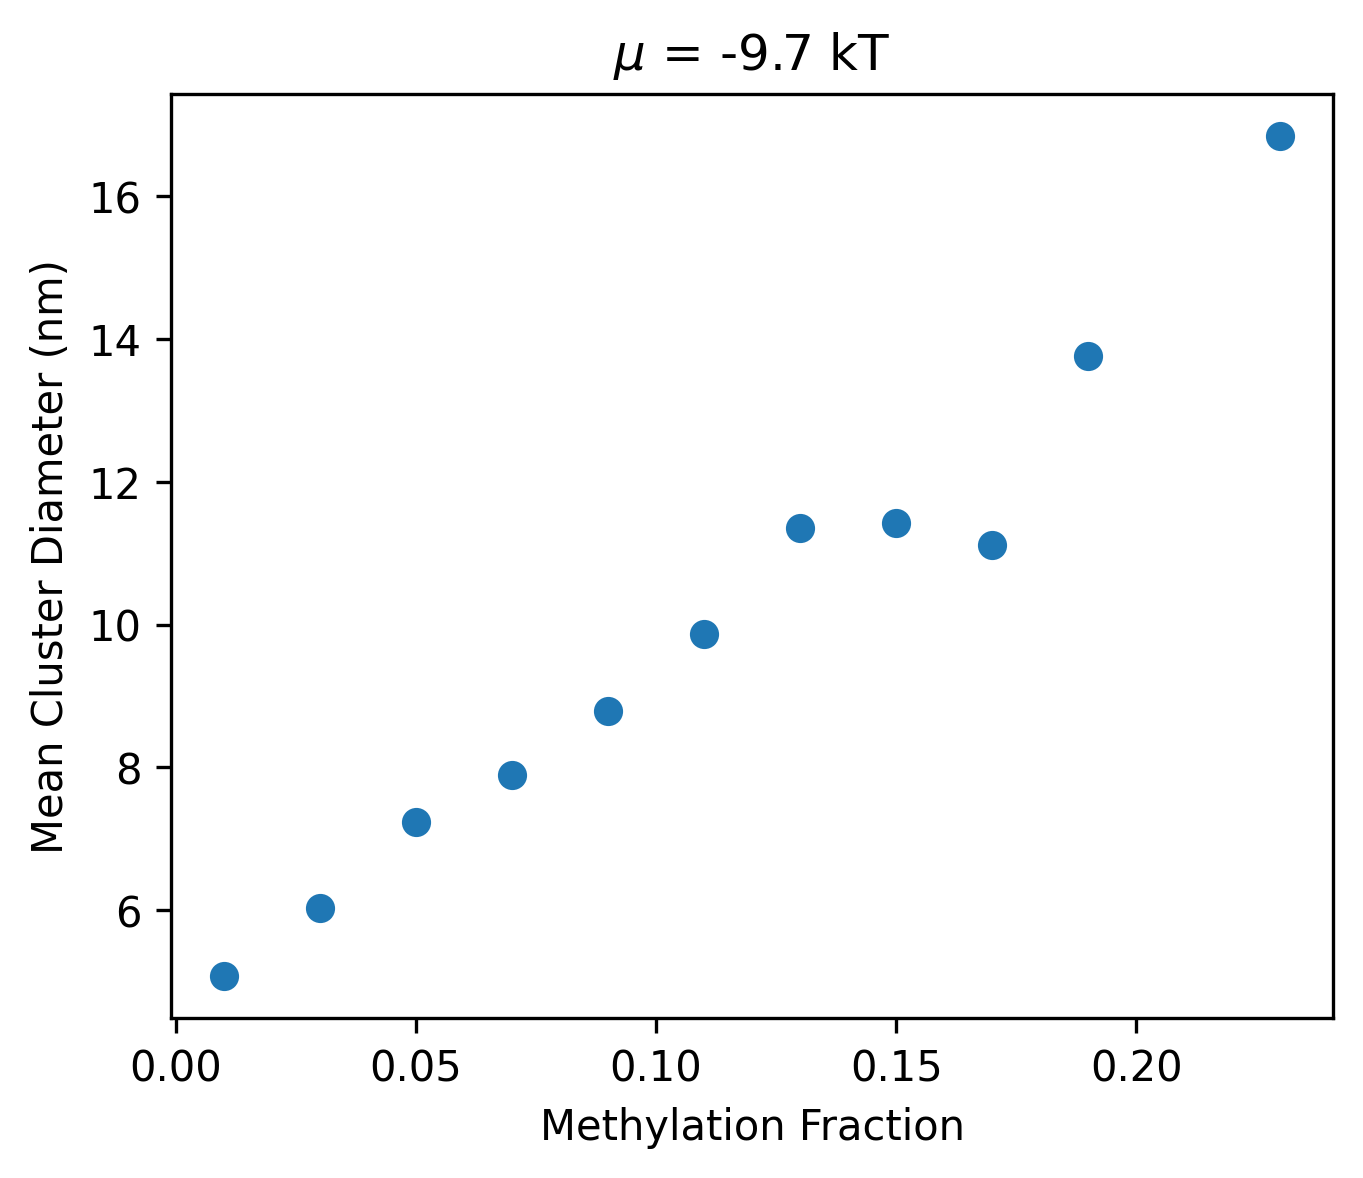

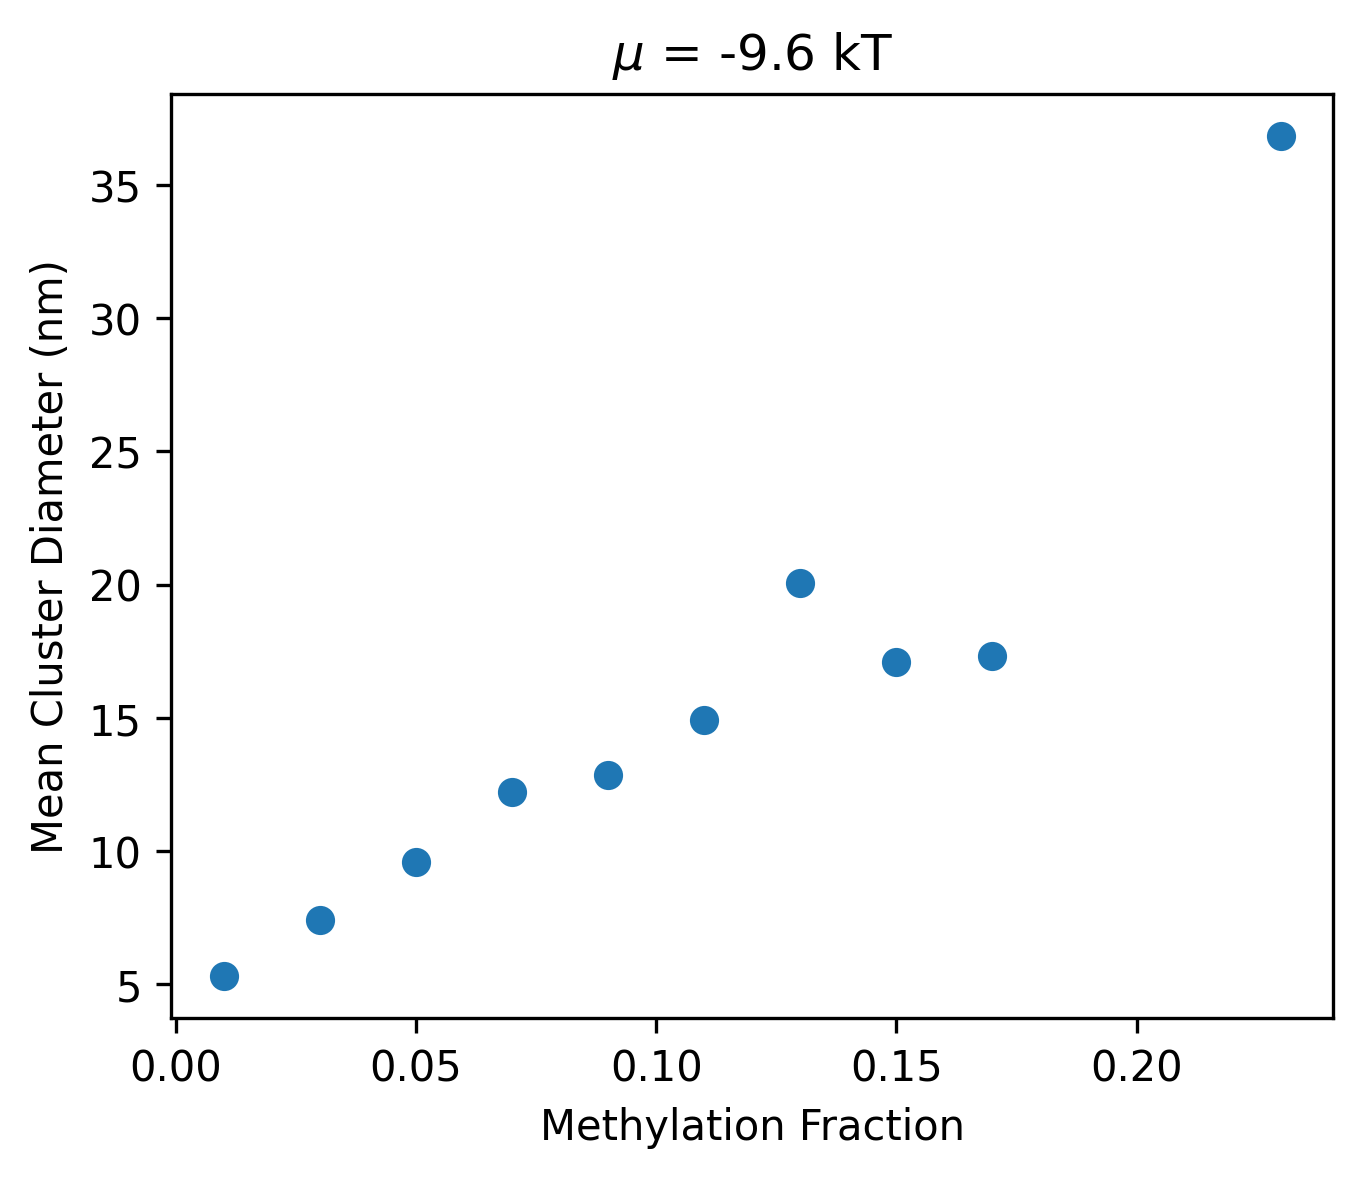

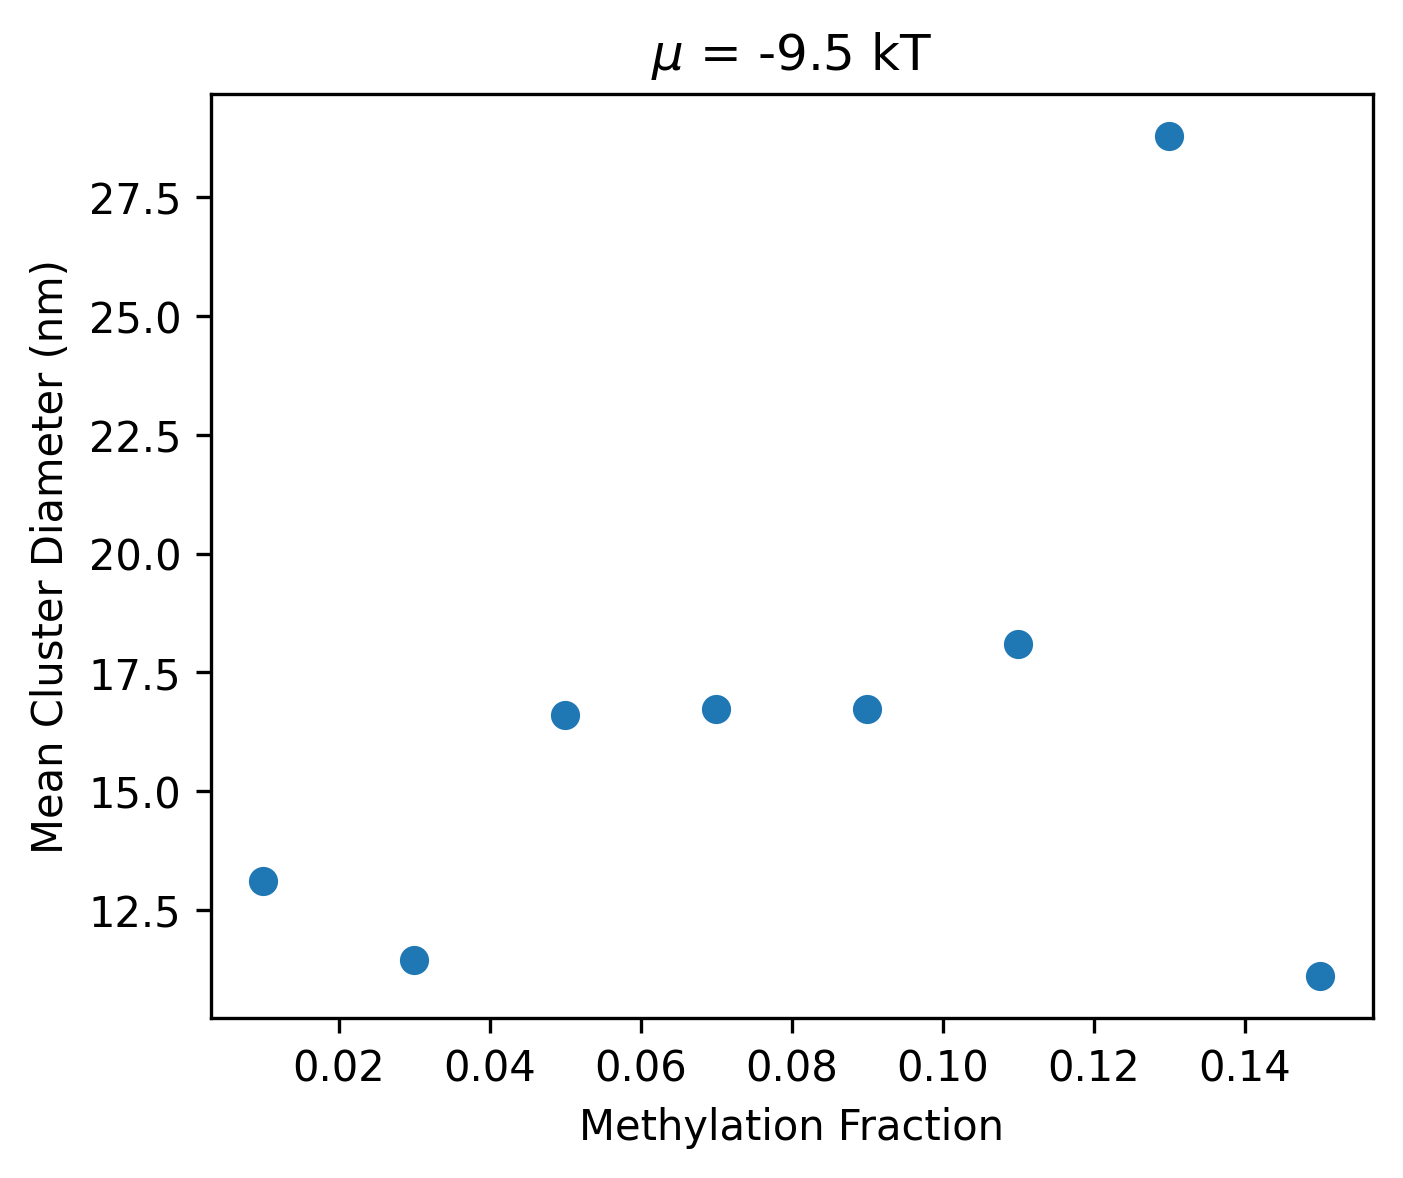

In [13]:
bins = [5, 12, 24, 36, 48]
for mu, cluster_size_dist in cluster_sizes_by_mu_methyl_frac.items():
    
    # We will include a separate subplot for each methylation fraction
    methyl_fracs_ = list(cluster_size_dist.keys())
    methyl_fracs_ = np.sort(methyl_fracs_)
    n_fracs = len(methyl_fracs_)
    
    # Calculate mean cluster sizes at each methylation fraction
    mean_cluster_sizes = []
    frac_methyl_centered = []
    for i, methyl_frac_ in enumerate(methyl_fracs_):
        mean_cluster_sizes.append(np.average(cluster_size_dist[methyl_frac_]))
        frac_methyl_centered.append(round(methyl_frac_ + 0.01, 2))
    
    # Plot the mean cluster size as a function of methylation fraction
    plt.figure(figsize=(5,4), dpi=300)
    plt.scatter(frac_methyl_centered, mean_cluster_sizes)
    plt.xlabel("Methylation Fraction")
    plt.ylabel("Mean Cluster Diameter (nm)")
    plt.title(fr"$\mu$ = {mu} kT")
    plt.show()